## Imports

In [2]:
from questrade_api import Questrade
import numpy as np
from datetime import datetime, timedelta
import riskfolio as rp
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

## Access Questrade API and Load Portfolios

In [4]:
q = Questrade(refresh_token='YOUR_NEW_REFRESH_TOKEN')

In [5]:
positions_TFSA = q.account_positions('YOUR_ACCOUNT_NUMBER_1')
positions_RRSP = q.account_positions('YOUR_ACCOUNT_NUMBER_2')

## Calculate Portfolio Weights

In [6]:
ETFs_to_remove=[] #['ZWC.TO','VFV.TO','IAK','MCHI','ICLN','PKW', 'ARKK','INFL','XMB.TO']
securities_to_remove=['HSUV.U.TO'] # Remove cash

In [7]:
def calculate_portfolio_weights(data):
    # Extracting the positions list from the data dictionary
    positions = data['positions']
    total_market_value = sum(position['currentMarketValue']
                             for position in positions
                             # Remove positions based on conditions:
                             # 1. currentMarketValue > 0
                             # 2. Symbol does not start with a digit (GICs)
                             if position['currentMarketValue'] > 0 and not position['symbol'][0].isdigit() and position['symbol'] not in securities_to_remove and position['symbol'] not in ETFs_to_remove) 
    weights = {}

    for position in positions:
        if position['currentMarketValue'] > 0 and not position['symbol'][0].isdigit() and position['symbol'] not in securities_to_remove and position['symbol'] not in ETFs_to_remove:
            weight = position['currentMarketValue'] / total_market_value
            weights[position['symbol']] = weight

    return weights


TFSA_portfolio_weights = calculate_portfolio_weights(positions_TFSA)
RRSP_portfolio_weights = calculate_portfolio_weights(positions_RRSP)

In [8]:
def combine_portfolios(weights1, weights2):
    combined_weights = {}

    # Add the weights from the first portfolio
    for symbol, weight in weights1.items():
        combined_weights[symbol] = weight

    # Add the weights from the second portfolio, combining them if the symbol already exists
    for symbol, weight in weights2.items():
        if symbol in combined_weights:
            combined_weights[symbol] += weight
        else:
            combined_weights[symbol] = weight

    # Normalize the weights so that they sum up to 1
    total_weight = sum(combined_weights.values())
    for symbol in combined_weights:
        combined_weights[symbol] /= total_weight

    return combined_weights

In [9]:
total_portfolio=combine_portfolios(TFSA_portfolio_weights,RRSP_portfolio_weights)

# Check if done correctly:
sum(total_portfolio.values())

1.0

In [10]:
custom_mu = pd.DataFrame.from_dict(total_portfolio, orient='index', columns=['Weights'])
custom_mu=custom_mu.T
custom_mu

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
Weights,5.7063%,3.2911%,2.3550%,2.7118%,1.7769%,4.8944%,0.5823%,3.7970%,4.4603%,3.0277%,...,0.8997%,2.1727%,0.6126%,2.4636%,1.5203%,0.6437%,8.1526%,14.8176%,6.9265%,20.1033%


In [11]:
# Pie chart plot function: 

def plot_weights(weights):
    plt.figure(figsize=(10, 10))
    plt.pie(weights.iloc[0], labels=weights.columns, autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '')
    plt.title("Portfolio Weights")
    plt.show()

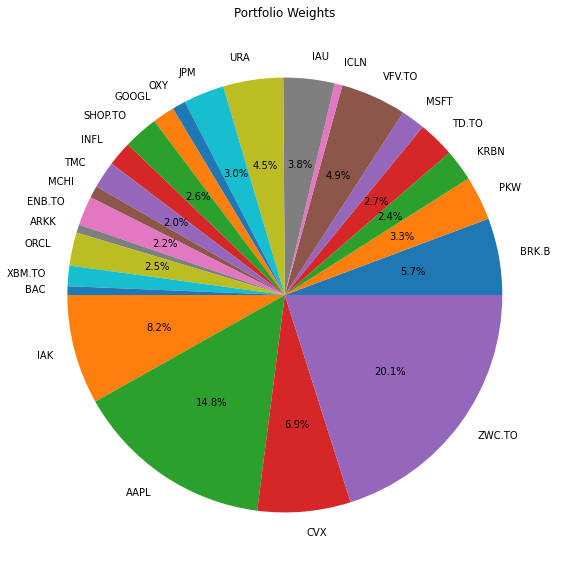

In [12]:
plot_weights(custom_mu)

Tthe influence of initial weights on the final outcome is an important factor to consider:

Nature of Optimization Algorithms: Many optimization algorithms used in MVO, especially those based on gradient descent or similar iterative methods, start from an initial point (i.e., the initial weights) and move step-by-step towards a point that minimizes or maximizes the objective function (e.g., the Sharpe ratio). The path these algorithms take can be heavily influenced by where they start.

Local Maxima in the Objective Function: In complex optimization problems like MVO, the objective function's landscape can have multiple peaks (local maxima) and valleys (local minima). If an algorithm starts closer to a particular local maximum, it is more likely to converge to that point rather than finding the global maximum, especially if the algorithm is not designed to escape local maxima.

Impact on Convergence: When initial weights are significantly different, they might position the starting point of the optimization close to a different local maximum. This can lead the algorithm to converge to a suboptimal solution that is heavily influenced by the proximity of the starting point to this local maximum.

Sensitivity to Initial Conditions: MVO is known for its sensitivity to input data, including initial weights. Small changes in these weights can lead to different paths taken by the optimization algorithm, resulting in different final portfolios.

In [13]:
# Even Redistribution

def rebalance_even_distribution(weights):
    num_assets = len(weights.columns)
    even_weight = 1.0 / num_assets
    rebalanced_weights = {symbol: even_weight for symbol in weights.columns}
    rebalanced_weights_df = pd.DataFrame(rebalanced_weights, index=weights.index)

    return rebalanced_weights_df

In [14]:
custom_mu_balanced=rebalance_even_distribution(custom_mu)
custom_mu_balanced

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
Weights,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,...,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%,4.0000%


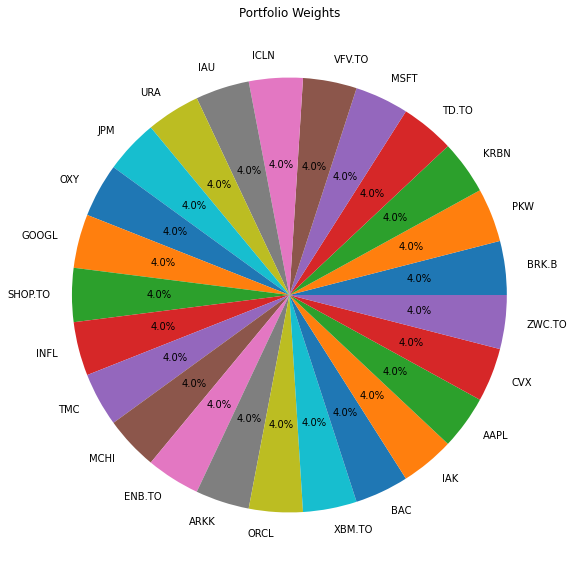

In [15]:
plot_weights(custom_mu_balanced)

When the efficient frontier in portfolio optimization is flat, and the optimal portfolio selected is simply the furthest data point to the left, it typically indicates certain characteristics or limitations in the data or the assumptions used in the optimization process. Here's what this might mean:

Dominance of Low-Risk Assets: A flat efficient frontier often suggests that one or a few low-risk assets are dominating the portfolio. These assets provide the best risk-return trade-off compared to others in the set. As a result, the optimization heavily favors these assets, making the efficient frontier appear flat as increasing risk does not proportionately increase expected returns.

Limited Diversification Benefit: The flatness of the frontier might also indicate that adding riskier assets does not provide a significant diversification benefit. This can happen if the riskier assets either have poor expected returns relative to their risk or are highly correlated with the lower-risk assets.

Constraints and Bounds: If there are constraints on the asset weights (e.g., maximum or minimum weight limits), these can sometimes lead to a flat efficient frontier, particularly if the constraints are tight. This can force the optimizer to select a narrow range of portfolios that do not show a wide variation in risk-return profiles.

Risk-Free Rate and Risk Aversion Factor: The level of the risk-free rate and the risk aversion factor used in the optimization can also impact the shape of the efficient frontier. If the risk-free rate is high or the risk aversion factor is set in a way that heavily penalizes risk, the optimizer may favor low-risk assets disproportionately.

In [16]:
def randomize_weights_with_thresholds(df, min_threshold=0.01, max_threshold=0.10):
    n_assets = len(df.columns)
    min_total = min_threshold * n_assets
    max_total = max_threshold * n_assets

    while True:
        weights = np.random.rand(n_assets)
        weights /= weights.sum()  # Normalize to sum up to 1

        if (weights >= min_threshold).all() and (weights <= max_threshold).all() and min_total <= weights.sum() <= max_total:
            break

    new_df = pd.DataFrame([weights], columns=df.columns)
    return new_df


In [17]:
custom_mu_random = randomize_weights_with_thresholds(custom_mu)
custom_mu_random

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
0,4.8536%,2.7663%,5.0067%,5.1249%,2.4372%,2.1709%,2.9107%,3.2546%,1.3157%,6.0147%,...,4.1567%,1.4510%,5.3195%,6.1375%,5.0862%,3.6661%,5.8334%,2.4285%,2.6201%,5.3309%


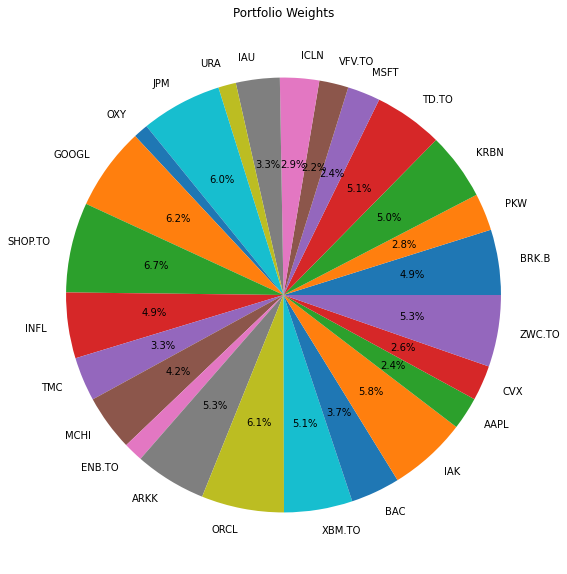

In [18]:
plot_weights(custom_mu_random)

Resampling: Employ techniques like resampling to generate multiple estimates of expected returns and covariances and optimize over these to get more stable and diversified portfolios.

In [19]:
# Check type:
custom_mu_random['BRK.B']

0   4.8536%
Name: BRK.B, dtype: float64

## Calculate Daily Returns 

In [20]:
# Filter securties and extract symbols from portfolios:

def filter_positions(data,weights):
    return [
        {'symbol': pos['symbol'], 'symbolId': pos['symbolId']}
        for pos in data['positions']
        if pos['currentMarketValue'] > 0 and not pos['symbol'][0].isdigit() and pos['symbol'] in weights.columns.values
    ]

def extract_symbols(data_TFSA, data_RRSP,weights):
    """
    Combines and deduplicates symbols from TFSA and RRSP data.
    """
    filtered_data_TFSA = filter_positions(data_TFSA,weights)
    filtered_data_RRSP = filter_positions(data_RRSP,weights)

    # Combining and removing duplicates
    combined_data = {d['symbol']: d['symbolId'] for d in filtered_data_TFSA + filtered_data_RRSP}

    df_combined_symbols = pd.DataFrame(list(combined_data.items()), columns=['symbol', 'symbolId']).set_index('symbol')

    return df_combined_symbols

In [21]:
symbols=extract_symbols(positions_TFSA,positions_RRSP,custom_mu_random)
symbols.head()

,symbolId
symbol,
BRK.B,9991
PKW,21802255
KRBN,31557137
TD.TO,38938
MSFT,27426


In [22]:
# Calculating start and end date for historial returns: 

def calc_start_end(days,years=1):

    # Calculate end_time as the previous day to the current day
    current_day = datetime.now()
    end_time = current_day - timedelta(days=1)

    start_time = end_time - timedelta(days=days * years)

    start_time_formatted = start_time.strftime('%Y-%m-%dT%H:%M:%S-05:00')
    end_time_formatted = end_time.strftime('%Y-%m-%dT%H:%M:%S-05:00')
    
    return start_time_formatted,end_time_formatted

In [23]:
start_time_formatted,end_time_formatted =calc_start_end(365,3)
start_time_formatted, end_time_formatted

('2021-01-18T10:08:40-05:00', '2024-01-18T10:08:40-05:00')

In [24]:
# Extract historial returns Questrade's API markets_candles endpoint:

def calc_daily_returns(start_time_formatted, end_time_formatted, symbols, q):
    daily_returns = pd.DataFrame()

    for symbol, symbolId in symbols.itertuples(index=True, name=None):
        candles_data = q.markets_candles(symbolId, interval='OneDay', startTime=start_time_formatted, endTime=end_time_formatted)

        if candles_data and 'candles' in candles_data:
            closes = [candle['close'] for candle in candles_data['candles']]
            dates = [candle['start'][:10] for candle in candles_data['candles']]

            if not closes:
                print(f"No closing data for {symbol}")
                continue

            returns = pd.Series(closes, index=pd.to_datetime(dates)).pct_change().dropna()
            daily_returns[symbol] = returns

    daily_returns_cleaned = daily_returns.dropna()
    daily_returns_cleaned.index.name = 'Date'

    return daily_returns_cleaned

In [25]:
daily_returns=calc_daily_returns(start_time_formatted, end_time_formatted, symbols, q)
daily_returns.head()

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-13,0.8357%,0.5849%,0.0501%,-0.0973%,0.4329%,0.0199%,1.9938%,0.2938%,3.1511%,1.5887%,...,-0.3895%,0.6737%,-1.9010%,-0.8809%,-0.0814%,1.6638%,0.2667%,0.3893%,1.9777%,0.3241%
2021-09-14,-0.9717%,-1.7659%,-1.6270%,-0.4384%,0.9428%,-0.2486%,-0.6082%,0.6737%,-0.8833%,-1.7453%,...,-2.0947%,-0.6101%,-1.1086%,-2.8125%,-0.8143%,-2.6869%,-1.1666%,-0.9562%,-1.8067%,-0.4308%
2021-09-15,0.3535%,1.2167%,0.9160%,0.9051%,1.6778%,0.3490%,-1.3986%,-0.6110%,6.4983%,0.6940%,...,-1.0840%,0.6931%,0.8215%,1.5511%,2.5178%,0.7530%,1.1438%,0.6144%,2.1206%,0.4327%
2021-09-16,-0.2409%,0.0758%,-0.5043%,0.5333%,0.1312%,0.2484%,-0.6649%,-2.2541%,-3.3124%,-0.0443%,...,-1.7159%,-0.0393%,0.6366%,-0.5471%,-3.7373%,0.7723%,-0.4349%,-0.1610%,-0.9365%,-0.2693%
2021-09-17,-0.2703%,-0.5194%,0.3294%,-0.5546%,-1.7528%,-0.3568%,0.4909%,-0.1497%,-7.8255%,-0.2593%,...,1.1004%,-0.3344%,2.1085%,-0.9857%,-2.6622%,0.1236%,-0.6865%,-1.8348%,-0.5754%,-0.5130%


In [26]:
# Check NaN rows removed:
num_rows_with_nan = daily_returns.isna().any(axis=1).sum()
total_rows = daily_returns.shape[0]
num_rows_with_nan, total_rows

(0, 577)

## Calculate the covariance matrix

In [27]:
custom_cov=daily_returns.cov()
custom_cov

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
BRK.B,0.0128%,0.0108%,0.0047%,0.0068%,0.0103%,0.0074%,0.0091%,0.0010%,0.0136%,0.0122%,...,0.0058%,0.0060%,0.0160%,0.0093%,0.0115%,0.0134%,0.0108%,0.0117%,0.0087%,0.0057%
PKW,0.0108%,0.0150%,0.0071%,0.0084%,0.0134%,0.0096%,0.0141%,0.0009%,0.0179%,0.0138%,...,0.0101%,0.0063%,0.0270%,0.0126%,0.0150%,0.0168%,0.0118%,0.0143%,0.0098%,0.0068%
KRBN,0.0047%,0.0071%,0.0516%,0.0065%,0.0075%,0.0047%,0.0053%,0.0018%,0.0087%,0.0074%,...,0.0065%,0.0033%,0.0077%,0.0071%,0.0078%,0.0095%,0.0060%,0.0085%,0.0073%,0.0044%
TD.TO,0.0068%,0.0084%,0.0065%,0.0135%,0.0057%,0.0048%,0.0071%,0.0001%,0.0086%,0.0105%,...,0.0064%,0.0056%,0.0121%,0.0063%,0.0104%,0.0132%,0.0077%,0.0067%,0.0074%,0.0058%
MSFT,0.0103%,0.0134%,0.0075%,0.0057%,0.0351%,0.0142%,0.0165%,0.0012%,0.0196%,0.0105%,...,0.0128%,0.0040%,0.0370%,0.0188%,0.0128%,0.0121%,0.0087%,0.0245%,0.0048%,0.0055%
VFV.TO,0.0074%,0.0096%,0.0047%,0.0048%,0.0142%,0.0095%,0.0103%,-0.0003%,0.0112%,0.0087%,...,0.0067%,0.0033%,0.0230%,0.0104%,0.0083%,0.0098%,0.0071%,0.0139%,0.0041%,0.0042%
ICLN,0.0091%,0.0141%,0.0053%,0.0071%,0.0165%,0.0103%,0.0371%,0.0043%,0.0282%,0.0113%,...,0.0189%,0.0069%,0.0447%,0.0123%,0.0204%,0.0148%,0.0086%,0.0166%,0.0103%,0.0074%
IAU,0.0010%,0.0009%,0.0018%,0.0001%,0.0012%,-0.0003%,0.0043%,0.0078%,0.0070%,0.0001%,...,0.0035%,0.0017%,0.0024%,0.0007%,0.0059%,-0.0001%,-0.0002%,0.0010%,0.0029%,0.0015%
URA,0.0136%,0.0179%,0.0087%,0.0086%,0.0196%,0.0112%,0.0282%,0.0070%,0.0760%,0.0151%,...,0.0196%,0.0117%,0.0453%,0.0145%,0.0328%,0.0182%,0.0131%,0.0200%,0.0205%,0.0097%
JPM,0.0122%,0.0138%,0.0074%,0.0105%,0.0105%,0.0087%,0.0113%,0.0001%,0.0151%,0.0245%,...,0.0108%,0.0062%,0.0227%,0.0108%,0.0149%,0.0237%,0.0136%,0.0123%,0.0099%,0.0069%


## 2. Estimating Mean Variance Portfolios with Custom Parameters

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [28]:
# Check weights and covariance are same dimensions:
custom_mu_balanced.shape[1],custom_cov.shape[1]

(25, 25)

In [29]:
def get_average_risk_free_rate(start_date, end_date):
    # Format the start and end dates for yfinance (YYYY-MM-DD)
    start_date_formatted = datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%S%z').strftime('%Y-%m-%d')
    end_date_formatted = datetime.strptime(end_date, '%Y-%m-%dT%H:%M:%S%z').strftime('%Y-%m-%d')

    # Fetch historical data for the 10-year Treasury Bond (symbol: ^TNX for Yahoo Finance)
    bond_data = yf.download("^TNX", start=start_date_formatted, end=end_date_formatted)

    # Calculate the average yield
    average_yield = (bond_data['Close'].mean())/100

    return average_yield

In [30]:
average_risk_free_rate = get_average_risk_free_rate(start_time_formatted, end_time_formatted)
average_risk_free_rate

[*********************100%***********************]  1 of 1 completed


0.028246432362564047

In [31]:
# Building the portfolio object
port = rp.Portfolio(returns=daily_returns)

# Calculating optimal portfolio
port.mu = custom_mu_random/100 # Custom mean vector.
port.cov = custom_cov/100 # Custom covariance matrix.

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = average_risk_free_rate/100 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
weights,0.0000%,0.0000%,0.2093%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,5.2922%,0.0000%,0.0000%,4.0186%,0.0000%,0.0000%,89.1166%


### 2.2 Plotting portfolio composition

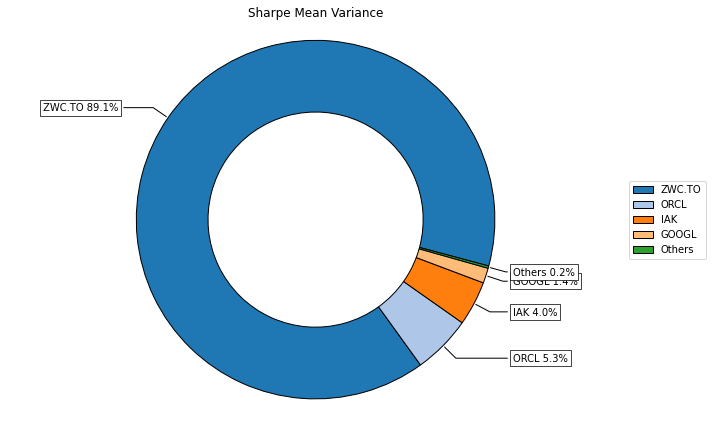

In [32]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [33]:
def calc_efficient_frontier(points):
    # Number of points of the frontier
    frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
    return frontier

frontier=calc_efficient_frontier(50)
frontier.T.head()

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
0,0.0001%,0.0001%,0.2179%,4.2969%,0.0000%,22.0558%,0.0000%,40.2877%,0.0000%,0.0001%,...,0.0001%,1.4568%,0.0000%,0.0001%,0.0000%,0.0000%,0.0003%,0.0000%,0.0001%,31.6837%
1,0.0000%,0.0000%,0.6201%,0.0000%,0.0000%,0.0000%,0.0000%,13.5775%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,3.8478%,0.0000%,0.0000%,3.2070%,0.0000%,0.0000%,78.6842%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,6.0764%,0.0000%,0.0000%,6.8734%,0.0000%,0.0000%,84.9008%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.1284%,...,0.0000%,0.0000%,0.0000%,10.0534%,0.0000%,0.0000%,19.7343%,0.0000%,0.0000%,61.0255%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,7.4360%,...,0.0000%,0.0000%,0.0000%,12.6162%,0.0000%,0.0000%,26.7050%,0.0000%,0.0000%,44.7292%


In [34]:
# Plotting the efficient frontier

def plot_efficient_frontier(label,mu,cov,returns):
    # mu = Expected returns
    # cov = Covariance matrix
    # returns = Returns of the assets
    ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                          rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                          marker='*', s=16, c='r', height=6, width=10, t_factor=252, ax=None)
    return ax

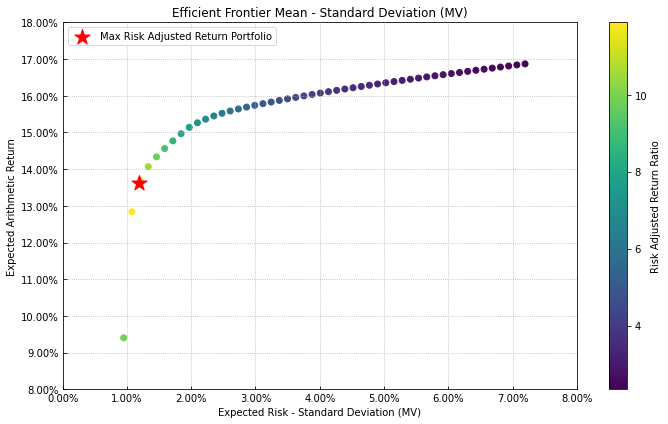

In [35]:
ax=plot_efficient_frontier('Max Risk Adjusted Return Portfolio',port.mu,port.cov,port.returns)

## 3. Estimating Mean Risk Portfolios with Custom Mean Parameter

In this part I will calculate optimal portfolios for several risk measures using a custom mean parameter as input. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

### 3.1 Calculating the portfolio that maximizes Return/CVaR ratio.

In [36]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.5228%,...,0.0000%,0.0000%,0.0000%,8.5624%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,83.3233%


### 3.2 Plotting portfolio composition

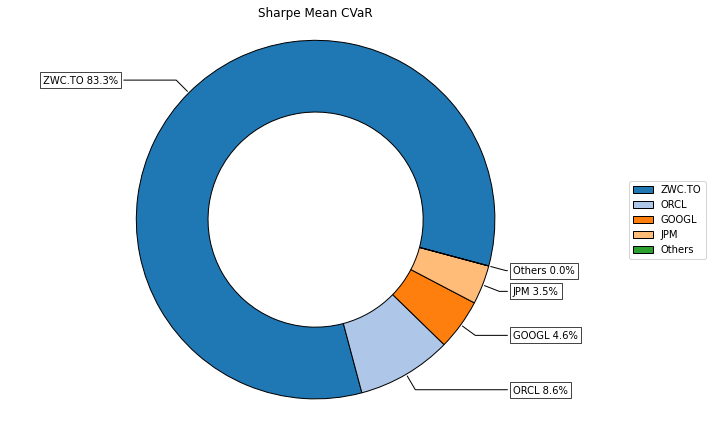

In [37]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Calculate efficient frontier

In [38]:
#points = 50 # Number of points of the frontier

#frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)


frontier=calc_efficient_frontier(50)
frontier.T.head()

,BRK.B,PKW,KRBN,TD.TO,MSFT,VFV.TO,ICLN,IAU,URA,JPM,...,MCHI,ENB.TO,ARKK,ORCL,XBM.TO,BAC,IAK,AAPL,CVX,ZWC.TO
0,0.0000%,0.0000%,0.3914%,13.7549%,0.0000%,17.3581%,0.0000%,49.0603%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,19.4353%
1,0.0000%,0.0000%,0.0000%,3.1611%,0.0000%,0.0000%,0.0000%,28.9492%,0.0000%,2.2405%,...,0.0000%,0.0000%,0.0000%,3.2486%,0.0000%,0.0000%,8.5470%,0.0000%,0.0000%,53.8535%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,10.3737%,0.0000%,4.5122%,...,0.0000%,0.0000%,0.0000%,6.9621%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,77.4576%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,4.5981%,...,0.0000%,0.0000%,0.0000%,9.2043%,0.0000%,0.0000%,5.2191%,0.0000%,0.0000%,76.1697%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,7.9074%,...,0.0000%,0.0000%,0.0000%,10.2895%,0.0000%,0.0000%,15.5713%,0.0000%,0.0000%,54.5607%


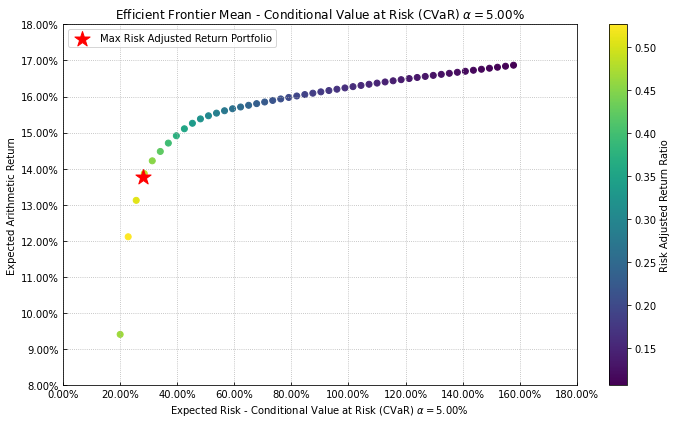

In [39]:
ax=plot_efficient_frontier('Max Risk Adjusted Return Portfolio',port.mu,port.cov,port.returns)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures

In [43]:
# Risk Measures available:

# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

def optimize_multiple_portfolios(riskMeasures):

    w_s = pd.DataFrame([])

    for i in riskMeasures:
        w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
        w_s = pd.concat([w_s, w], axis=1)

    w_s.columns = rms
    
    return w_s

In [44]:
w_s=optimize_multiple_portfolios(rms)

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
BRK.B,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PKW,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
KRBN,0.21%,0.14%,0.00%,0.25%,0.00%,0.00%,0.00%,0.57%,2.21%,7.47%,4.41%,8.04%,2.66%
TD.TO,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
MSFT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
VFV.TO,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
ICLN,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IAU,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
URA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
JPM,0.00%,0.00%,0.00%,0.00%,0.00%,3.52%,17.20%,29.78%,0.00%,0.00%,0.00%,0.00%,0.00%


<Axes: >

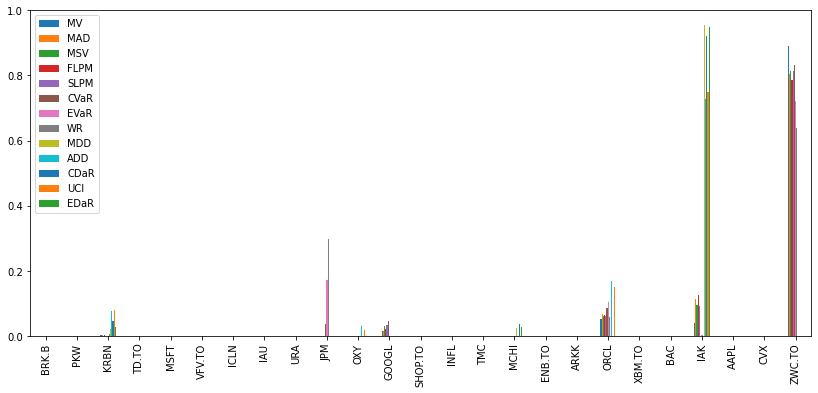

In [45]:
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## Conclusions 

### Initial Weights of Portfolio 

Scenario 1: Starting with an Unbalanced Portfolio
Optimization Favors Stocks with Highest Weights: This could be happening due to the relative scale of returns and risks in your initial data. If the stocks with the highest weights also have relatively good performance (either in terms of higher returns or lower risk), the optimizer might naturally favor them. This is especially true if these stocks also exhibit lower correlations with other assets, leading to better risk-adjusted returns.

Efficient Frontier Shows Expected Trade-Off: This is normal behavior. The efficient frontier should show the trade-off between risk and return, and it being non-flat suggests that your optimization is working correctly under these initial conditions.

Scenario 2: Starting with a Fully Balanced Portfolio
Solid Range of Stocks Selected: This is likely because starting with a balanced portfolio doesn't introduce any initial bias towards particular stocks. The optimization algorithm has more flexibility to shift weights based on the risk-return characteristics of each asset.

Efficient Frontier is Flat: This might indicate that the incremental increase in expected return does not compensate for the additional risk when moving along the frontier. It can also suggest that the risk-return profiles of the assets are quite similar or the returns are not high enough to justify taking on more risk.

Dealing with These Issues
Review Input Data: Ensure your return estimates and covariance matrix are realistic and accurately reflect the current market conditions. Sometimes overly conservative or aggressive assumptions can skew optimization results.

Constraints: Introducing constraints like maximum weight limits for individual stocks or minimum diversification requirements (like the number of effective assets) can help prevent the optimizer from concentrating too much on certain assets.

Objective Function: Experiment with different objective functions. For example, using a utility-based objective function with a risk aversion parameter can provide a different perspective, balancing return and risk more explicitly.

Robust Optimization: Consider using robust optimization techniques that account for estimation errors in expected returns and covariances.

Resampling: Employ techniques like resampling to generate multiple estimates of expected returns and covariances and optimize over these to get more stable and diversified portfolios.

Alternative Models: Explore other portfolio construction models like Black-Litterman, which can incorporate your views on certain assets, or factor-based models that might offer different insights.

Regular Rebalancing: If initial weights heavily influence outcomes, regular rebalancing based on updated data and constraints can help mitigate this issue over time.

### The timeframe for historical data

In mean-variance optimization (MVO) this is crucial as it impacts the estimation of expected returns and risk (volatility and covariance). 

Shorter Timeframes
Typically 1 to 3 years: Useful for capturing recent market trends and conditions.
Pros: More relevant to current market dynamics, which may be beneficial in fast-changing markets.
Cons: May miss longer-term trends and may be more influenced by short-term volatility or anomalies.

Longer Timeframes
Typically 5 to 10 years: Can encompass a full market cycle, including periods of both bull and bear markets.
Pros: Provides a more comprehensive view of asset behavior over different market conditions.
Cons: Includes historical data that may no longer be relevant to current market dynamics.

Considerations:
Investment Horizon: Align the data timeframe with your investment horizon. For short-term investments, recent data is more relevant. For long-term investments, consider a longer historical period.

Asset Characteristics: Some assets (like emerging market stocks) may require a longer period to capture their risk-return profile accurately.

Market Conditions: In rapidly changing markets, recent data may be more indicative of future performance.

Data Availability: For some assets, especially newer ones, you may be limited by the available data.

Regular Updates: Regularly update the dataset to include recent market data.

Robustness Checks: Perform optimization with different timeframes to check the robustness of the portfolio allocation.

## Next Steps

1. Combine a variety of different randomly sampled initial weight porfolios and combine the optimized weight result for each- plot just that EF

2. also at the same time, for each randomly sampled porfolio,combine the optimized weight result for each risk meausure- plot just that EF

aggreation:
50 random samples x 13 risk measures